In [1]:
%load_ext autoreload

In [2]:
import os
import numpy as np
import pandas as pd
import json
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle
#sns.set(style='darkgrid')
sns.set(style='darkgrid', context='notebook',font_scale=1.5)

In [3]:
%autoreload
import sys
sys.path.insert(0,'../')
from scripts.loader import *
import mytools as tl

# Datos

In [4]:
data_path = os.path.join('..', 'Datasets', 'Interiors')
resp_path = os.path.join(data_path, 'responses')
subj_path = os.path.join(data_path, 'human_scanpaths')
figs_path = os.path.join(os.getcwd(), 'figs')

In [5]:
data_path

'../Datasets/Interiors'

In [6]:
trials_data    = load_trials_properties(os.path.join(subj_path,'..', 'trials_properties.json'))
subjs_response = load_human_scanpaths(os.path.join(resp_path, 'human_scanpaths'), human_subject='all')
responses_data = tl.get_responses_features(subjs_response)
#responses_data = responses_data[responses_data.response_x <= 1024]
responses_data.head()

,subj,img,max_fixations,scanpath_length,target_found,target_found_response,response_size,distance_to_target,distance_to_last_fix,delta_time_response,response_x,response_y,target_bbox_x,target_bbox_y,response_target_relative_x,response_target_relative_y
0,41,grayscale_11_opensource.jpg,13,10,False,False,29,266.810794,213.164661,49.599536,486.0,447.0,228,559,-258.0,112.0
1,41,grayscale_18_housebeautiful.jpg,9,10,False,False,47,329.200547,411.615026,9.666707,520.0,538.0,797,400,277.0,-138.0
2,41,grayscale_100_oliva.jpg,5,3,True,False,19,202.054448,204.544005,5.633140,714.0,218.0,713,381,-1.0,163.0
3,41,grayscale_17_oliva.jpg,3,2,False,False,35,297.692795,208.923431,4.266648,433.0,316.0,186,490,-247.0,174.0
4,41,grayscale_16_housebeautiful.jpg,3,4,False,False,19,568.198029,223.650531,2.900187,762.0,442.0,158,421,-604.0,-21.0


# Performance acumulada

## A mano

<AxesSubplot:xlabel='max_fixations', ylabel='target_found'>

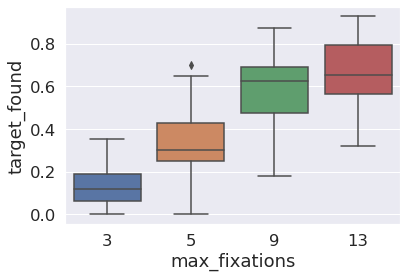

In [7]:
df=responses_data.groupby(['subj', 'max_fixations']).mean()['target_found']
sns.boxplot(data=df.reset_index(), x='max_fixations', y='target_found')

Using target found online


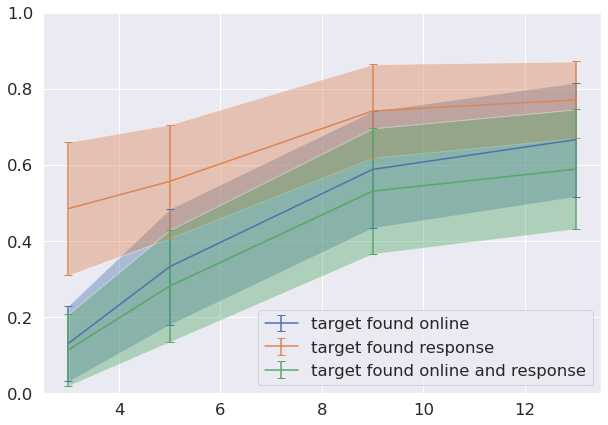

In [8]:
def cumulative_mean_performance_response(df, max_fix_key ='max_fixations', use_response=True):
    
    print('Using target found online')
    so = df.groupby(['subj', max_fix_key])['target_found'].sum()
    co = df.groupby(['subj', max_fix_key])['target_found'].count()
    perf_o = (so/co).groupby(['max_fixations']).agg(['mean', 'std'])
    
    if use_response:
        sr = df.groupby(['subj', max_fix_key])['target_found_response'].sum()
        cr = df.groupby(['subj', max_fix_key])['target_found_response'].count()
        perf_r = (sr/cr).groupby(['max_fixations']).agg(['mean', 'std'])
        # join with online target found
        perf_o = perf_o.join(perf_r, lsuffix='_online', rsuffix='_response')
        df['target_found_online_response'] = df['target_found'] & df['target_found_response']
        so_r = df.groupby(['subj', max_fix_key])['target_found_online_response'].sum()
        co_r = df.groupby(['subj', max_fix_key])['target_found_online_response'].count()
        perf_o_r = (so_r/co_r).groupby(['max_fixations']).agg(['mean', 'std'])
        # join with online target found
        perf_o = perf_o.join(perf_o_r)
        perf_o.rename(columns={'mean': 'mean_online_response', 'std': 'std_online_response'}, inplace=True)
        #perf_o.reset_index(inplace=True)
        
    return perf_o
 
aux  = cumulative_mean_performance_response(responses_data).reset_index()

_, ax = plt.subplots(1,1,figsize=(10,7))
ax.errorbar(aux['max_fixations'], aux['mean_online'], yerr = aux['std_online'], 
            label ='target found online', capsize=4)
ax.fill_between(aux['max_fixations'], 
                aux['mean_online']-aux['std_online'], 
                aux['mean_online']+aux['std_online'],
                alpha=0.4)

ax.errorbar(aux['max_fixations'], aux['mean_response'], yerr = aux['std_response'],
            label = 'target found response', capsize=4)
ax.fill_between(aux['max_fixations'], 
                aux['mean_response']-aux['std_response'], 
                aux['mean_response']+aux['std_response'], 
                alpha=0.4)

ax.errorbar(aux['max_fixations'], aux['mean_online_response'], yerr = aux['std_online_response'],
            label = 'target found online and response', capsize=4)
ax.fill_between(aux['max_fixations'],
                aux['mean_online_response']-aux['std_online_response'], 
                aux['mean_online_response']+aux['std_online_response'], alpha=0.4)

ax.set_ylim(0,1)
ax.legend()

plt.savefig(os.path.join(figs_path, f'lineplot_performance_responses.png'))

In [9]:
responses_data.scanpath_length.value_counts()

4     1433
3     1172
5     1017
6      783
2      482
8      467
7      464
9      421
10     313
12     228
13     213
11     179
14     141
Name: scanpath_length, dtype: int64

## Usando las funciones del repo

No handles with labels found to put in legend.


[Cumulative performance] Computing human mean for Interiors dataset


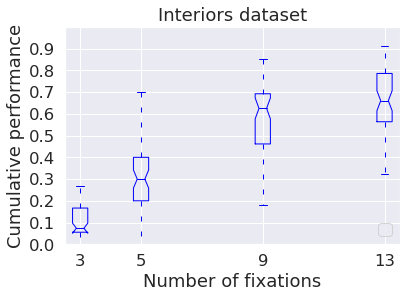

In [10]:
%autoreload
from Metrics.scripts.cumulative_performance import CumulativePerformance
perf = CumulativePerformance(dataset_name='Interiors', number_of_images=134, max_scanpath_length=15, compute=True)
#perf.compute_cumulative_performance(subjs_response[42])
perf.add_human_mean(humans_scanpaths_dir=os.path.join(resp_path, 'human_scanpaths'), humans_color='blue')
#perf.add_human_mean(humans_scanpaths_dir=subj_path, humans_color='blue')
perf.plot(save_path=figs_path)

# Performance: scanpath + respuesta

In [11]:
results_path = '../Results/Interiors_Responses_dataset/nnIBS/subjects_predictions'

In [12]:
def load_results_responses(res_path = '../Results/Interiors_Responses_dataset/nnIBS/subjects_predictions/'):
    import json
    #print(os.listdir(res_path))
    dout = []
    dout2 = []
    missing = []
    onefix = []
    for subj_file in sorted([file for file in os.listdir(res_path) if 'fixations' in file]):
        with open(os.path.join(res_path, subj_file)) as json_file:
            d = json.load(json_file)
            for img in d.keys():
                for metric in d[img].keys():
                    val   = list(d[img][metric].values())
                    n_fix = len(val)
                    avg_r = np.mean(val)
                    # 'mean_no_response'
                    avg_nr = np.mean(val[:-1])
                    # 'mean_last_two'
                    avg_last_fix = np.mean(val[-3:-1])
                    if len(list(val))==0:
                        missing.append((subj_file, img, metric, 'length 0'))
                    elif np.nan in val:
                        missing.append((subj_file, img, metric, 'nans'))
                    elif len(val) ==1:
                        onefix.append((subj_file, img, metric, 'one fix'))    
                    dout.append({'subj':int(subj_file[8:10]), 'img':img , 'metric':metric, 'n_fix':n_fix,
                                 'response':val[-1], 'mean_response': avg_r, 'mean_no_response':avg_nr, 'mean_last_two':avg_last_fix})
                    for i,f in enumerate(val):
                        if i==len(val)-1:
                            nsacc = 'response'
                        elif i==len(val)-2:
                            nsacc = 'last'
                        else:
                            nsacc = i
                        dout2.append({'subj':int(subj_file[8:10]), 'img':img , 'metric':metric, 'n_fix':n_fix,
                                 'val':val[i], 'nsacc': nsacc, 'mean_response': avg_r, 'mean_no_response':avg_nr, 'mean_last_two':avg_last_fix})
                        
                        
    return pd.DataFrame(dout),pd.DataFrame(dout2), missing, onefix

df_out, df_out_all, miss, onefix = load_results_responses(res_path=results_path)
print(f'Cantidad de datos con errores: {len(miss)}')
print(f'Cantidad de datos con una fijación: {len(onefix)}')

Cantidad de datos con errores: 0
Cantidad de datos con una fijación: 0


In [13]:
# No hay errores pero sin embargo hay NaNs
print(f'Cantidad de datos que no puede mirar la respuesta ni ultimas dos fijaciones: {df_out.mean_no_response.isna().sum()}')

Cantidad de datos que no puede mirar la respuesta ni ultimas dos fijaciones: 0


In [14]:
df_out.shape, df_out_all.shape, len(onefix)

((29252, 8), (173384, 9), 0)

In [15]:
df_out_all.columns

Index(['subj', 'img', 'metric', 'n_fix', 'val', 'nsacc', 'mean_response',
       'mean_no_response', 'mean_last_two'],
      dtype='object')

## Crear columna distancia a la fijación del último mapa


### Sanity check

In [16]:
# Comprobamos si nfix (que seria mas un nsac) que se lee del json coincide con la cantidad de csv guardados por sacada
aux1 = df_out_all[df_out_all.metric=='AUC'].groupby(['subj','img']).apply(len)
aux2 = (aux1 == df_out_all[df_out_all.metric=='AUC'].groupby(['subj','img']).apply(lambda x: x.iloc[0,:].n_fix))
aux2.sum() == aux2.shape[0]

True

In [17]:
# Comprobar si la cantidad de mapas coincide con la cantidad de sacadas del sujeto que siguieron en cada caso


### Carga de mapas

In [18]:
df_out_all.head()

,subj,img,metric,n_fix,val,nsacc,mean_response,mean_no_response,mean_last_two
0,1,grayscale_1_housebeautiful.jpg,AUC,8,0.797526,0,0.888021,0.872675,0.966146
1,1,grayscale_1_housebeautiful.jpg,AUC,8,0.956380,1,0.888021,0.872675,0.966146
2,1,grayscale_1_housebeautiful.jpg,AUC,8,0.854818,2,0.888021,0.872675,0.966146
3,1,grayscale_1_housebeautiful.jpg,AUC,8,0.707682,3,0.888021,0.872675,0.966146
4,1,grayscale_1_housebeautiful.jpg,AUC,8,0.860026,4,0.888021,0.872675,0.966146


In [19]:
df_out_all.sample()

,subj,img,metric,n_fix,val,nsacc,mean_response,mean_no_response,mean_last_two
122920,41,grayscale_74_oliva.jpg,AUC,11,0.931641,8,0.74852,0.73099,0.714844


In [70]:
from visualsearch.grid import Grid

def get_fixation_maps_path_(subj, img, path):
    p = os.path.join(path, f'subject_{subj:02d}','probability_maps', img[:-4])
    fix_map_paths_ = sorted(os.listdir(p))
    return [os.path.join(p,fix_map_) for fix_map_ in fix_map_paths_]

def load_fixation_maps_(subj, img, path, disp_plot=False):
    maps = get_fixation_maps_path_(subj, img, path)
    fix_maps = [pd.read_csv(m).values for m in maps]
    print(f'Total saccades: {len(fix_maps)}')
    if disp_plot:
        last_map = fix_maps[disp_plot]*255
        with sns.plotting_context("talk"):
            plt.imshow(last_map)
    return np.array(fix_maps)

fs = load_fixation_maps_(1, 'grayscale_1_housebeautiful.jpg',results_path)

def get_model_next_fix_(maps, nsacc):
    return np.unravel_index(np.argmax(maps[nsacc,], axis=None), maps[nsacc,].shape)
    
def distance_between_fix_(subj, img, path, nsacc):
    # me traigo la fijacion del modelo
    maps      = load_fixation_maps_(subj, img, path)
    model_fix = get_model_next_fix_(maps, nsacc)
    # deberia cargar la fijacion de los sujetos, para eso puedo leer el scanpath del json
    rescale_scanpaths
    # deberia instanciar la grilla porque esos scanpaths estan en tamano original

    return 

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 28)

In [42]:
ind = np.unravel_index(np.argmax(fs[-1,], axis=None), fs[-1,].shape)
print(ind)

(7, 6)


In [43]:
fs[-1, 7,6], fs[-1,].max()

(0.4626138943156994, 0.4626138943156994)

In [36]:
def get_model_next_fix_(maps):
    
    return 

0.4252295819821454

[]


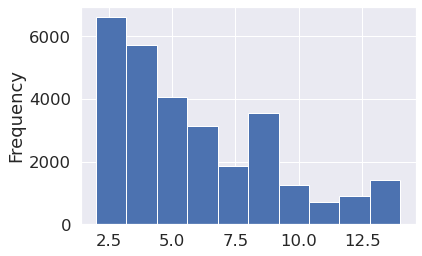

In [14]:
# Es en el caso que haya un solo valor de fijación, porque?
print(df_out[df_out.mean_no_response.isna()].n_fix.unique())
df_out.n_fix.plot(kind='hist');

## Comparación de rendimiento medio

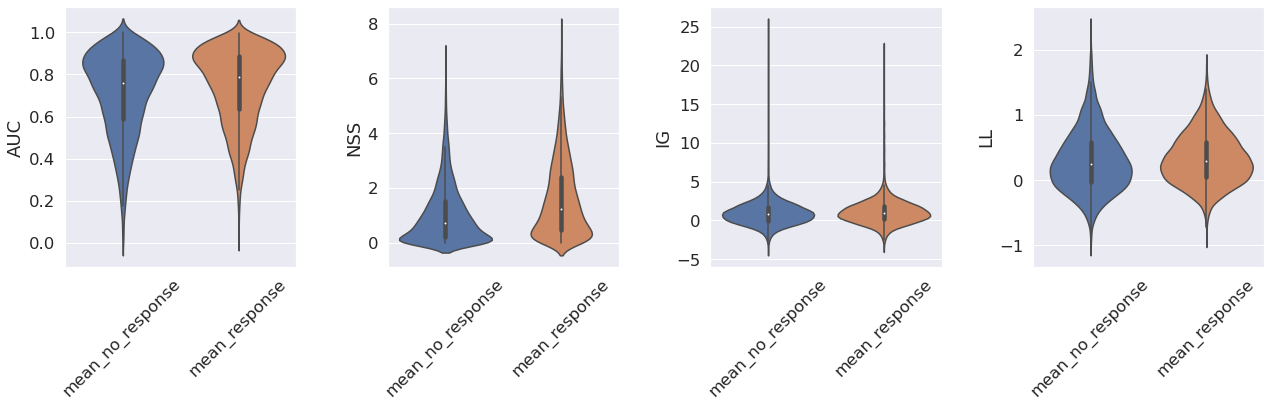

In [16]:
def compare_model_response_pred(df):
    return None

_, axs = plt.subplots(1,4, figsize=(18,6))
for ax, met in zip(axs.ravel(), df_out.metric.unique()):
    aux = df_out[df_out.metric==met][['mean_no_response', 'mean_response']]
    sns.violinplot(data=aux,ax=ax)
    ax.set_ylabel(met)
    ax.set_xticklabels(['mean_no_response','mean_response'], rotation=45) #ax.get_xticks()
plt.tight_layout()

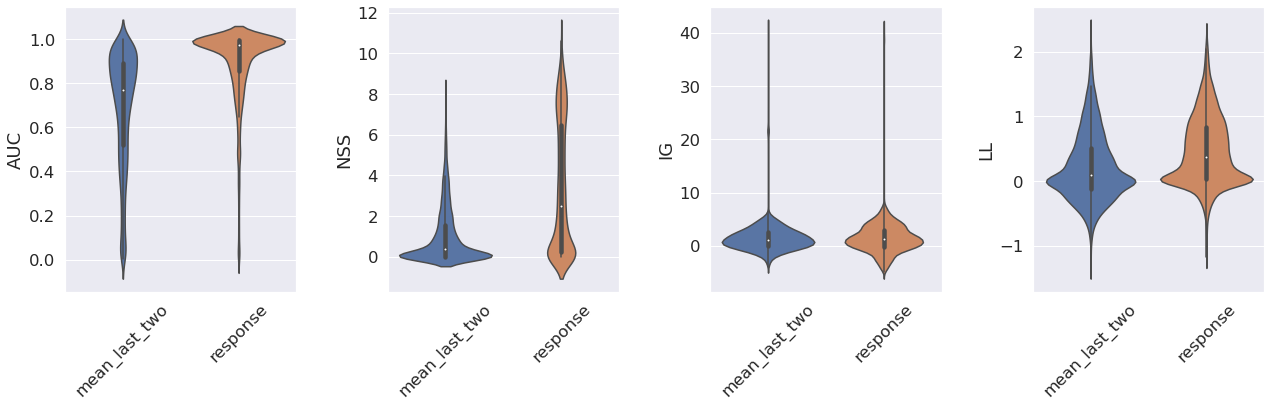

In [17]:
def compare_model_response_pred(df):
    return None

_, axs = plt.subplots(1,4, figsize=(18,6))
for ax, met in zip(axs.ravel(), df_out.metric.unique()):
    aux = df_out[df_out.metric==met][['mean_last_two','response']]
    sns.violinplot(data=aux,ax=ax,)
    ax.set_ylabel(met)
    ax.set_xticklabels(['mean_last_two','response'], rotation=45) #ax.get_xticks()
plt.tight_layout()

## Comparación por tipo de trial

In [18]:
# merge con todos los datos
print(df_out.shape, responses_data.shape)
df = df_out.merge(responses_data, on=['subj','img'])
df_all = df_out_all.merge(responses_data, on=['subj','img'])
print(df.shape, responses_data.shape)
df.head()
print(df.columns)

(29252, 8) (7313, 17)
(29252, 23) (7313, 17)
Index(['subj', 'img', 'metric', 'n_fix', 'response', 'mean_response',
       'mean_no_response', 'mean_last_two', 'max_fixations', 'scanpath_length',
       'target_found', 'target_found_response', 'response_size',
       'distance_to_target', 'distance_to_last_fix', 'delta_time_response',
       'response_x', 'response_y', 'target_bbox_x', 'target_bbox_y',
       'response_target_relative_x', 'response_target_relative_y',
       'target_found_online_response'],
      dtype='object')


In [19]:
aux = df[df.metric=='AUC'][['response', 'target_found']]
aux.head()

,response,target_found
0,0.995443,False
4,0.999349,True
8,0.998047,True
12,0.899089,False
16,0.991536,False


In [20]:
df.head()

,subj,img,metric,n_fix,response,mean_response,mean_no_response,mean_last_two,max_fixations,scanpath_length,...,distance_to_target,distance_to_last_fix,delta_time_response,response_x,response_y,target_bbox_x,target_bbox_y,response_target_relative_x,response_target_relative_y,target_found_online_response
0,1,grayscale_1_housebeautiful.jpg,AUC,8,0.995443,0.888021,0.872675,0.966146,9,8,...,21.540659,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False
1,1,grayscale_1_housebeautiful.jpg,NSS,8,0.351543,1.340039,1.481253,3.569346,9,8,...,21.540659,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False
2,1,grayscale_1_housebeautiful.jpg,IG,8,1.978444,-0.050026,-0.339807,1.063493,9,8,...,21.540659,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False
3,1,grayscale_1_housebeautiful.jpg,LL,8,0.002880,0.251722,0.287270,0.238036,9,8,...,21.540659,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False
4,1,grayscale_1_kitchen.jpg,AUC,6,0.999349,0.774306,0.729297,0.749349,9,6,...,10.630146,59.573148,0.666899,883.0,313.0,855,270,-28.0,-43.0,True


In [21]:
aux.target_found.head()

0     False
4      True
8      True
12    False
16    False
Name: target_found, dtype: bool

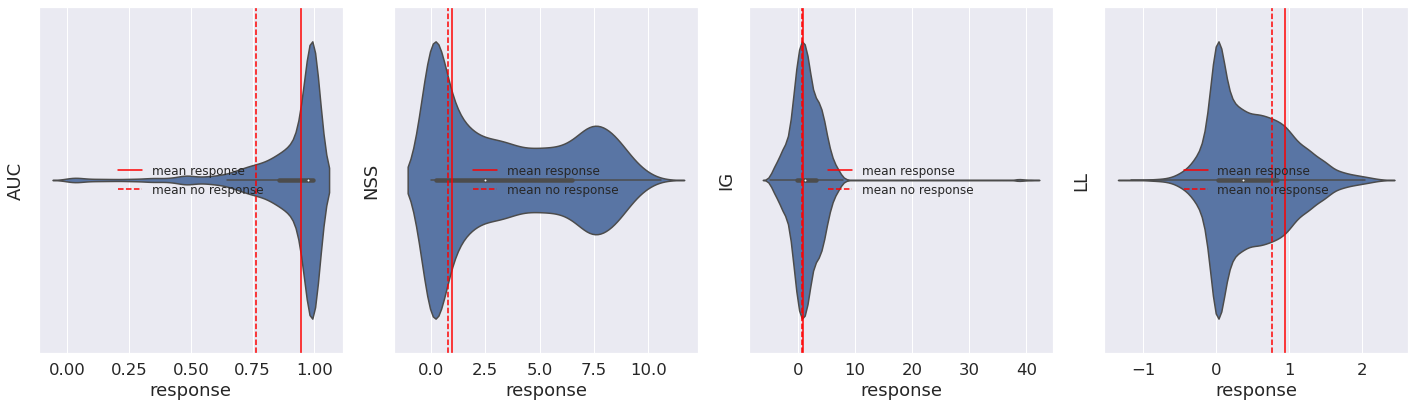

In [55]:
_, axs = plt.subplots(1,4, figsize=(20,6))
for ax, met in zip(axs.ravel(), df.metric.unique()):
    aux = df[df.metric==met][['response','mean_response', 'mean_no_response','target_found_response']]
    sns.violinplot(x='response',hue='target_found_response', data=aux, ax=ax, stat='percent', common_norm=False)
    lines = []
    lines.append(ax.axvline(df.mean_response.mean(),color='red',ls='-', label='a'))
    lines.append(ax.axvline(df.mean_no_response.mean(),color='red',ls='--'))
    leg = Legend(ax, lines, ['mean response', 'mean no response'], frameon=False, loc='center',fontsize=12)
    ax.add_artist(leg)
    ax.set_ylabel(met)
plt.tight_layout()

## Agregando categorias - 30/09

In [56]:
def cat_trial(row):
    if row['target_found'] and row['target_found_response']:
        return 'TFO & TFR'
    elif ~row['target_found'] and row['target_found_response']:
        return '~TFO & TFR'
    elif row['target_found'] and ~row['target_found_response']:
        return 'TFO & ~TFR'
    elif ~row['target_found'] and ~row['target_found_response']:
        return '~TFO & ~TFR'
    else:
        return 'ERROR'
responses_data_auxiliar_col = []
for idx, row in df.iterrows():
    responses_data_auxiliar_col.append(cat_trial(row))
df['found_category'] = responses_data_auxiliar_col
df.found_category.value_counts()
responses_data_auxiliar_col = []
for idx, row in df_all.iterrows():
    responses_data_auxiliar_col.append(cat_trial(row))
df_all['found_category'] = responses_data_auxiliar_col


In [57]:
df_all.head()

,subj,img,metric,n_fix,val,nsacc,mean_response,mean_no_response,mean_last_two,max_fixations,...,distance_to_last_fix,delta_time_response,response_x,response_y,target_bbox_x,target_bbox_y,response_target_relative_x,response_target_relative_y,target_found_online_response,found_category
0,1,grayscale_1_housebeautiful.jpg,AUC,8,0.797526,0,0.888021,0.872675,0.966146,9,...,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False,~TFO & TFR
1,1,grayscale_1_housebeautiful.jpg,AUC,8,0.956380,1,0.888021,0.872675,0.966146,9,...,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False,~TFO & TFR
2,1,grayscale_1_housebeautiful.jpg,AUC,8,0.854818,2,0.888021,0.872675,0.966146,9,...,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False,~TFO & TFR
3,1,grayscale_1_housebeautiful.jpg,AUC,8,0.707682,3,0.888021,0.872675,0.966146,9,...,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False,~TFO & TFR
4,1,grayscale_1_housebeautiful.jpg,AUC,8,0.860026,4,0.888021,0.872675,0.966146,9,...,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False,~TFO & TFR


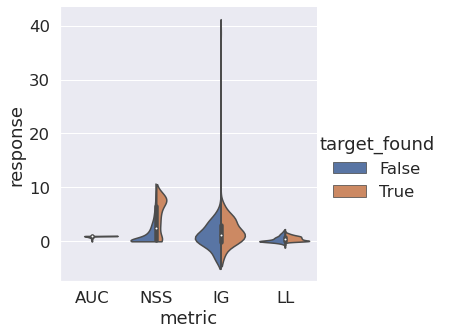

In [61]:
sns.catplot(
    data=df, x="metric", y="response", hue="target_found",
    kind="violin", bw=.25, cut=0, split=True,
)

/home/gastonb/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


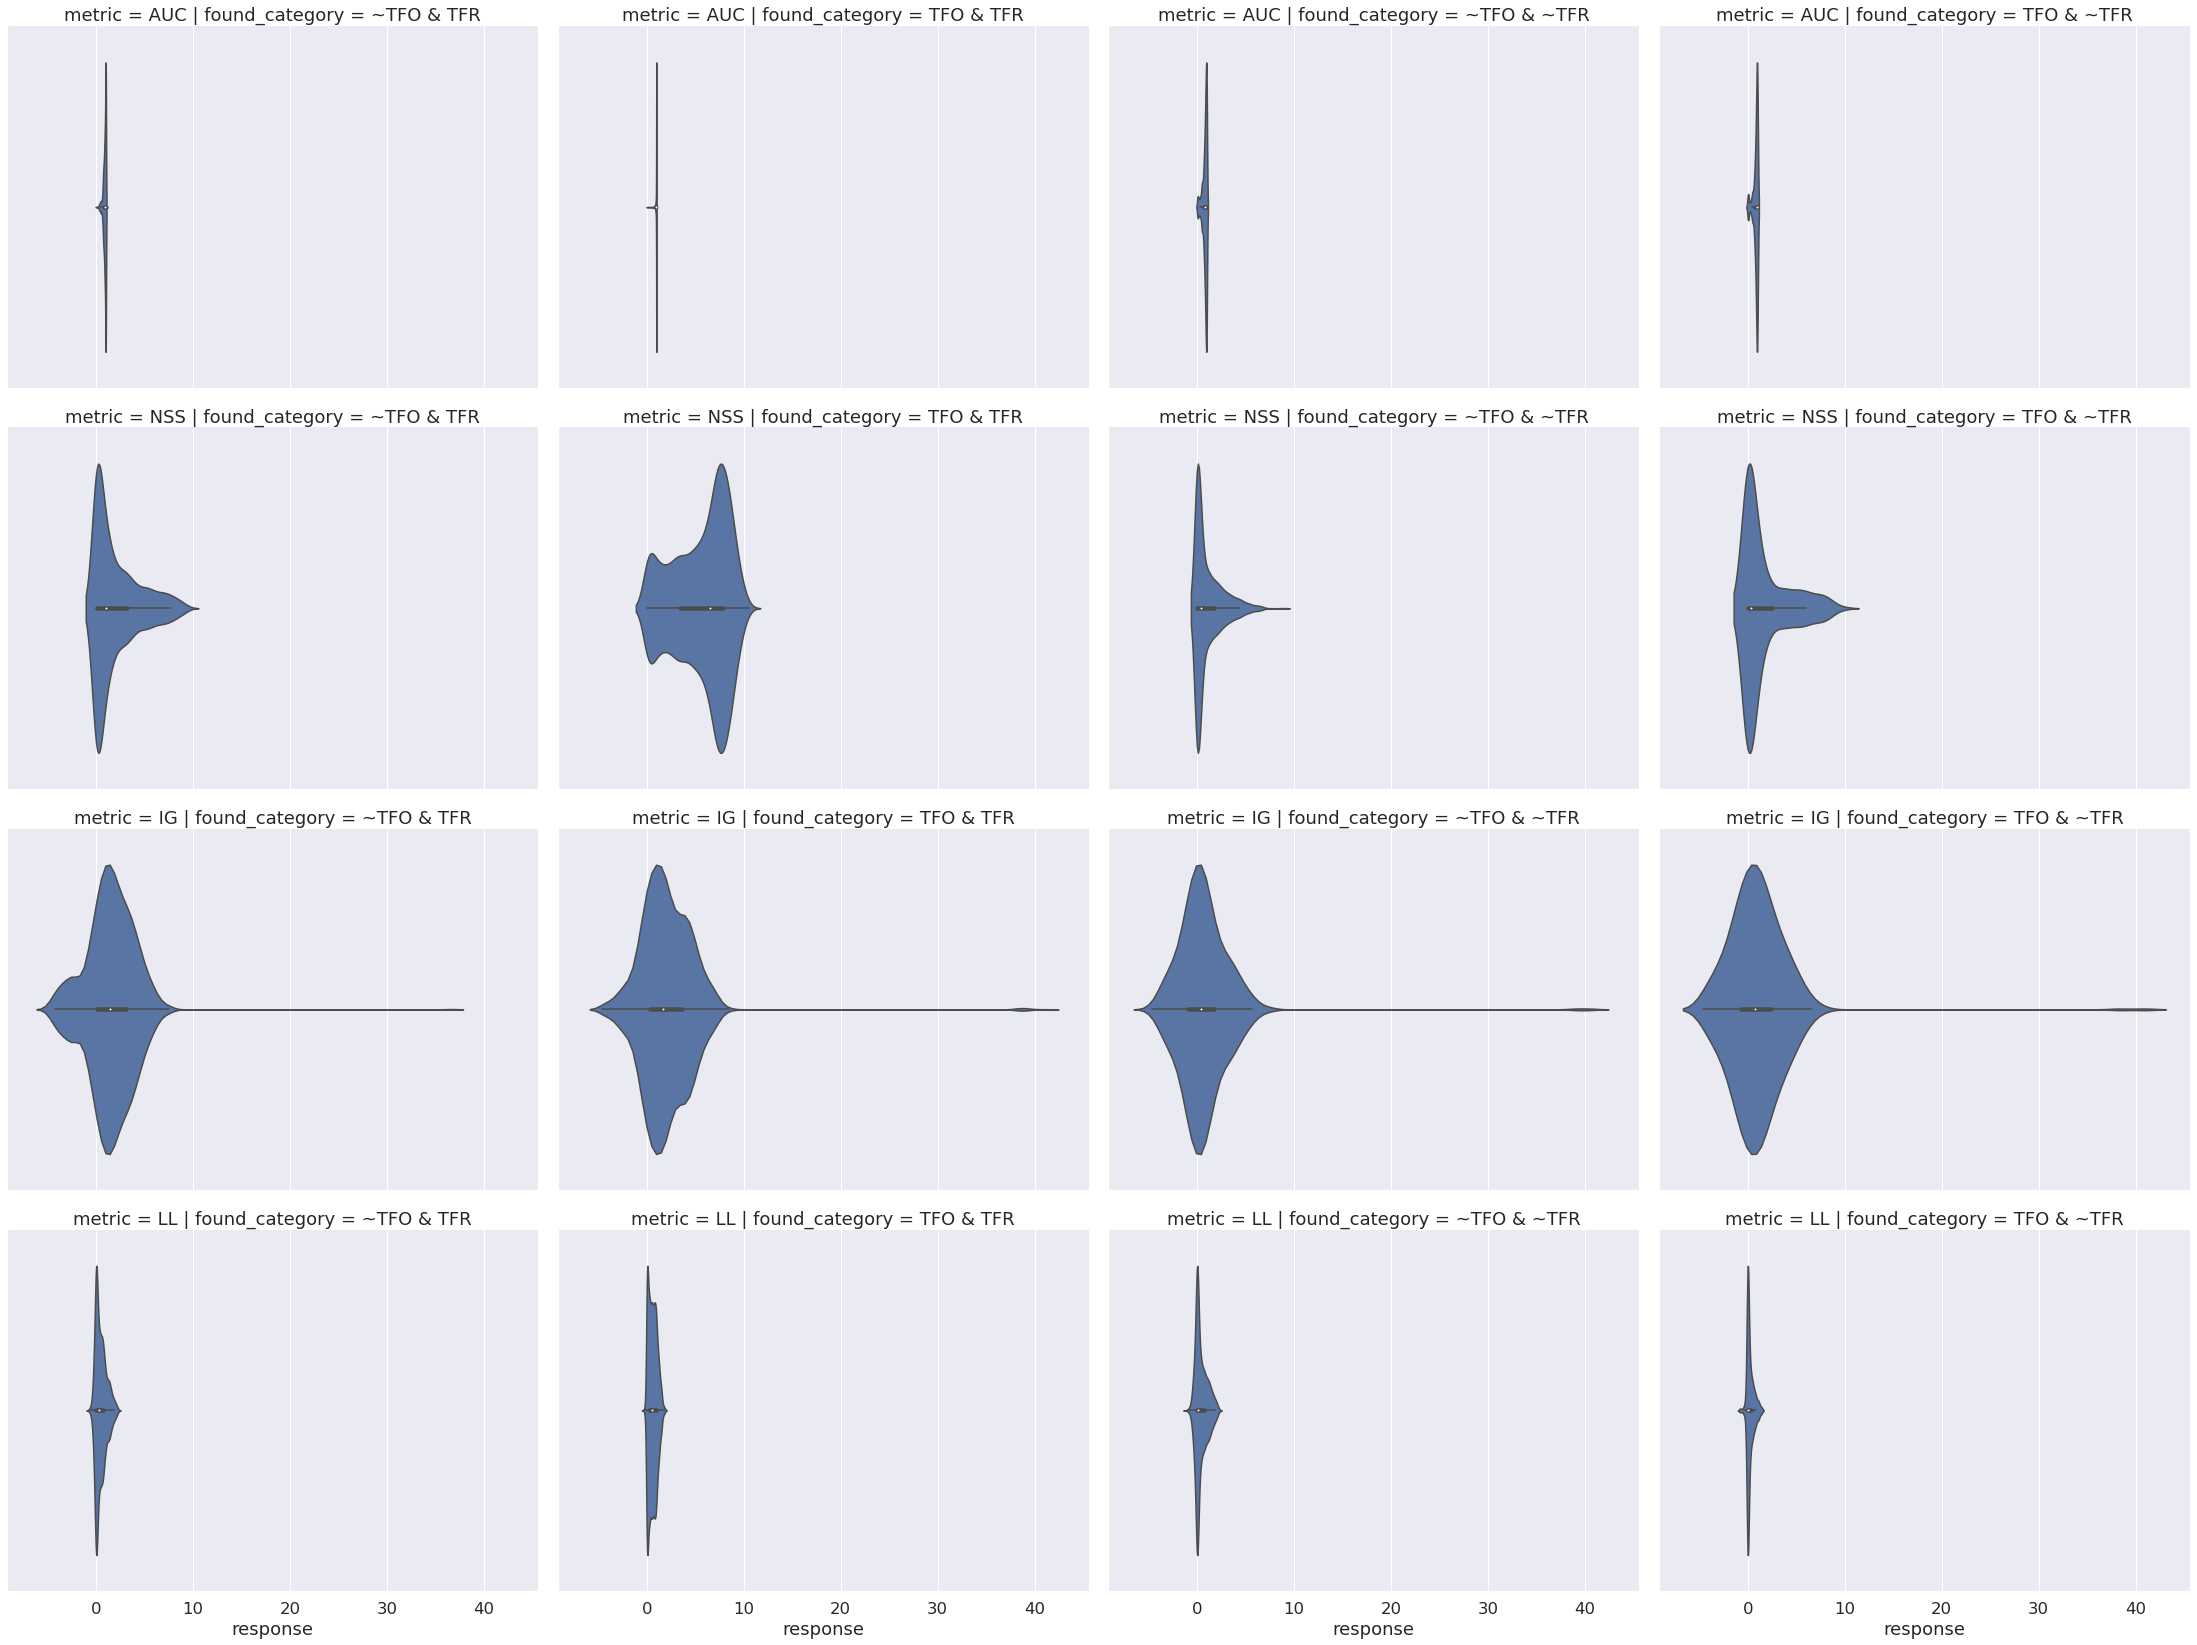

In [58]:
grid = sns.FacetGrid(df, row='metric', col='found_category',
                    palette="GnBu_d", height=5.8, aspect=1.33)

bins_hist = np.linspace(-4,4,30)
grid.map(sns.violinplot, 'response', stat='percent', alpha=0.8, common_norm=False);

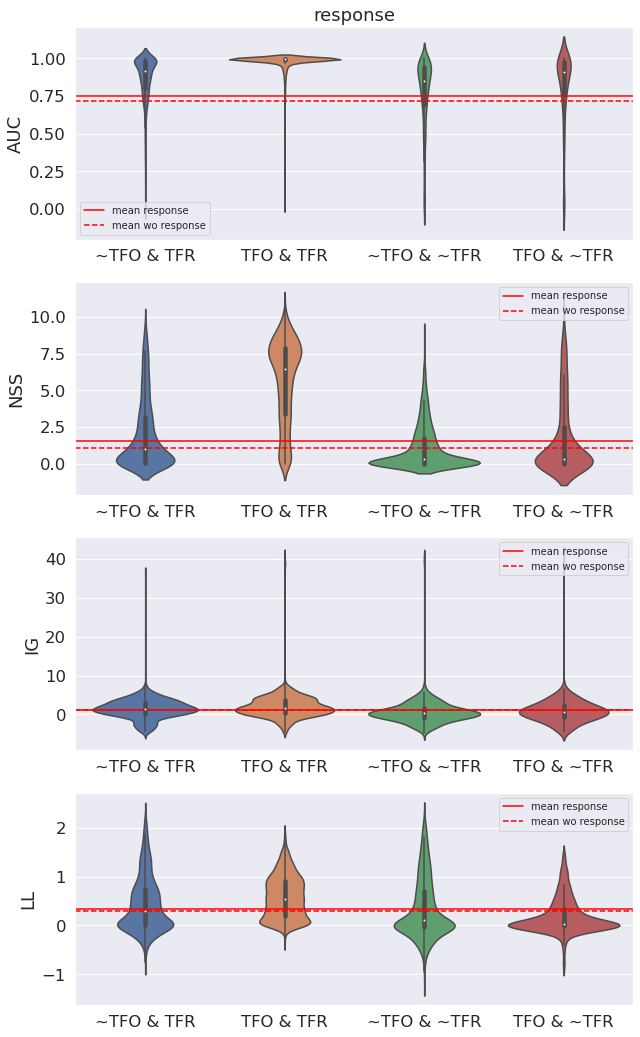

In [63]:
# AGREGAR EN CADA GRAFICO
# linea que sea la media del modelo para cada 

_, axs = plt.subplots(4,1, figsize=(10,18))
VAR = 'response'
axs[0].set_title(f'{VAR}');
for ax, met in zip(axs.ravel(), df.metric.unique()):
    aux = df[df.metric==met]
    aux = aux[~aux.mean_no_response.isna()]
    #sns.histplot(x='response',hue='target_found', data=aux, ax=ax, stat='percent', common_norm=False)
    sns.violinplot(y=VAR, x='found_category', data=aux, ax=ax)
    #sns.catplot(y=met, hue='target_found', data=aux, ax=ax)
    lines = []
    lines.append(ax.axhline(aux.mean_response.mean(),color='red',ls='-', label='mean response'))
    lines.append(ax.axhline(aux.mean_no_response.mean(),color='red',ls='--', label = 'mean wo response'))
    #leg = Legend(ax, lines, ['mean response', 'mean no response'], frameon=False, loc='center',fontsize=12)
    #ax.add_artist(leg)
    ax.legend(prop={'size': 10})
    ax.set_ylabel(met)
    ax.set_xlabel('')

In [42]:
df_all[(df_all.metric==met) & (df_all.nsacc.isin(['response','last']))].head()

,subj,img,metric,n_fix,val,nsacc,mean_response,mean_no_response,mean_last_two,max_fixations,...,distance_to_last_fix,delta_time_response,response_x,response_y,target_bbox_x,target_bbox_y,response_target_relative_x,response_target_relative_y,target_found_online_response,found_category
30,1,grayscale_1_housebeautiful.jpg,LL,8,0.002880,last,0.251722,0.287270,0.238036,9,...,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False,~TFO & TFR
31,1,grayscale_1_housebeautiful.jpg,LL,8,0.002880,response,0.251722,0.287270,0.238036,9,...,78.365809,0.466865,186.0,199.0,130,155,-56.0,-44.0,False,~TFO & TFR
54,1,grayscale_1_kitchen.jpg,LL,6,0.589875,last,0.258111,0.191759,0.123111,9,...,59.573148,0.666899,883.0,313.0,855,270,-28.0,-43.0,True,TFO & TFR
55,1,grayscale_1_kitchen.jpg,LL,6,0.589875,response,0.258111,0.191759,0.123111,9,...,59.573148,0.666899,883.0,313.0,855,270,-28.0,-43.0,True,TFO & TFR
74,1,grayscale_1_oliva.jpg,LL,5,1.278599,last,0.355577,0.124822,0.178579,13,...,38.296997,0.566944,153.0,627.0,106,605,-47.0,-22.0,True,TFO & TFR


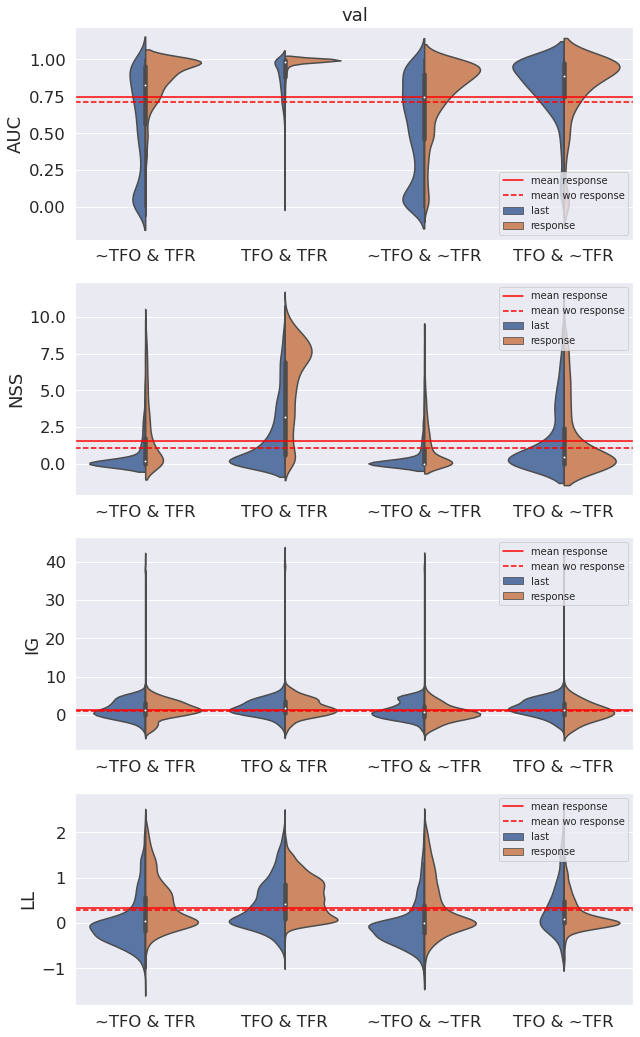

In [60]:
_, axs = plt.subplots(4,1, figsize=(10,18))
VAR = 'val'
axs[0].set_title(f'{VAR}');
for ax, met in zip(axs.ravel(), df_all.metric.unique()):
    aux = df_all[(df_all.metric==met) & (df_all.nsacc.isin(['response','last']))]
    aux = aux[~aux.mean_no_response.isna()]
    #sns.histplot(x='response',hue='target_found', data=aux, ax=ax, stat='percent', common_norm=False)
    sns.violinplot(y=VAR, x='found_category',hue='nsacc',split=True, data=aux, ax=ax)
    #sns.catplot(y=met, hue='target_found', data=aux, ax=ax)
    lines = []
    lines.append(ax.axhline(aux.mean_response.mean(),color='red',ls='-', label='mean response'))
    lines.append(ax.axhline(aux.mean_no_response.mean(),color='red',ls='--', label = 'mean wo response'))
    #leg = Legend(ax, lines, ['mean response', 'mean no response'], frameon=False, loc='center',fontsize=12)
    #ax.add_artist(leg)
    ax.legend(prop={'size': 10})
    ax.set_ylabel(met)
    ax.set_xlabel('')

In [ ]:
_, axs = plt.subplots(4,1, figsize=(10,18))
VAR = 'val'
axs[0].set_title(f'{VAR}');
for ax, met in zip(axs.ravel(), df_all.metric.unique()):
    aux = df_all[(df_all.metric==met) & (df_all.nsacc.isin(['response','last']))]
    aux = aux[~aux.mean_no_response.isna()]
    #sns.histplot(x='response',hue='target_found', data=aux, ax=ax, stat='percent', common_norm=False)
    sns.violinplot(y=VAR, x='found_category',hue='nsacc',split=True, data=aux, ax=ax)
    #sns.catplot(y=met, hue='target_found', data=aux, ax=ax)
    lines = []
    lines.append(ax.axhline(aux.mean_response.mean(),color='red',ls='-', label='mean response'))
    lines.append(ax.axhline(aux.mean_no_response.mean(),color='red',ls='--', label = 'mean wo response'))
    #leg = Legend(ax, lines, ['mean response', 'mean no response'], frameon=False, loc='center',fontsize=12)
    #ax.add_artist(leg)
    ax.legend(prop={'size': 10})
    ax.set_ylabel(met)
    ax.set_xlabel('')